In [39]:
# Aim: Obtain ESG Ratings for Biggest Companies in the World automatically

# Reason: ESG Data is a form of alternative data that can be used to analyse companies
# In a world constantly facing enviromental challenges and social issues; companies that have promising ESG data
# will be rewarding to support; and indeed invest in- thus the produced datasheet aims to reflect how diff companies
# around the world score on their ESG; and provide another layer of analysis on which companies are worth investing in.

###
import pandas as pd
import requests  
from bs4 import BeautifulSoup
import re
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
import time
from requests_html import AsyncHTMLSession
import asyncio
import math
from scipy import stats
###

In [40]:
index=1 # can be modified to no greater than 20
if index>20:
    print('Highest Page number is 20')
    index=20
#####
end=5 # can be modified for more pages (so long as nt more than 20)
#####
if end>20:
    end=20 # end has to be 20 (since the website looks at the top 1000 companies by market cap & each page features 50 company names)
if end<index: # prevents end from being smaller than index
    print('End is less than starting index.\nEnd has been set to the same as index.')
    end=index

start='https://disfold.com/world/companies/?page='

# WHY Disfold?
# > webpage that provides  extensive data on biggest companies (by market cap) around the world
# > readily supplied with good information; including Market Cap, Stock of Company and Country in which it originates and/or operates primarily
# > data is also updated regularly

og=pd.DataFrame(columns=['Company','Stock','Market_Cap','Country','Sector','Industry',])

#'ESG_Risk_Value','ESG_Risk_Catgeory','ESG_Controversy_lvl','ESG_Rating_Assesment'

morningstar_urls=[]
row_n=1
while index<=end: # paginates until no more pages can be found  
    url=start+str(index) # goes to specific page of url in start
    r=(requests.get(url)) 
    if r.status_code != 200: # if page does not give an ok response, exits code entirely
        out=False
        print(f'Code exited. HTTP status code {r.status_code} detected.')
        break
    else: # in the event of an error; notably error 429 (when too many requests are given to the website)
        out=True 
        soup=BeautifulSoup(r.text,'html.parser') # extracts HTML source code
        
        for e in (soup.find_all('tr')[1:]): # used to obtain all rows in the table of the website
            lis=(e.text.split('\n')) # for each row; text information is extracted and separated into a list
            n_lis=[]
            for i in lis:
                if i.strip()=='':
                    pass 
                else:
                    i=i.strip() # removes whitespace from elements
                    n_lis.append(i)
            company=n_lis[1] # company name
            market_cap=n_lis[2] # market cap of company
            stock=n_lis[3]  # stock of company
            country=n_lis[4] # country in which company operates primarily
            sector=n_lis[5] # Sector in which company primarily works in
            industry=n_lis[6] # specific industry in which company deals in
            stock=stock.replace('.','')
            if country=='United States': # used to query company info on another site (Morningstar> which has ESG info)
                # based on location of company and it's stock name
                query='https://www.morningstar.com/search/us-securities?query='+stock
            else:
                query='https://www.morningstar.com/search/foreign-securities?query='+stock
            
            # WHY Morningstar?

            # > financial firm service that provides investment research and management services
            # > having a 40% ownership stake in sustainalytics; has access to ESG data of more than 16,000 companies across the market
            # > based on a reliable industry standard
            # > in terms of webscraping; relatively easy to parse through multiple companies
            # > is also free to use (no need for pay for view)

            search_q=requests.get(query)
            q_soup=BeautifulSoup(search_q.text,'html.parser') # extracts HTML source code
            all_href=(q_soup.findAll('a',href=True))
            for e in all_href:
                if '/stocks/' in str(e):
                    stock_url=(e['href'])[:-5] # finds the necessary link for the particular stock
                    break
            
            esg_query='https://www.morningstar.com'+stock_url+'sustainability' # goes to the sustainability aspect of the site for the specific
            # stock; thereby showing info on the ESG rating for the company 
            morningstar_urls.append(esg_query)
            row=[company,stock,market_cap,country,sector,industry]
            
            
            """
            now, scraping of morningstar info is done separately using requests_html > no pop ups of pages as previously caused by selenium
            scraping of js pages can be done 'invisibly'
            """ 
            og.loc[len(og)] = row # rows now added immeidately to main datframe   
    index+=1
# scraping just this takes abt 1 min/pg
# per page (including loading js - abt 4-5 min)

In [41]:
og # To display how the dataframe looks like in pandas

,Company,Stock,Market_Cap,Country,Sector,Industry
0,Apple Inc.,AAPL,$2.067 T,United States,Technology,Consumer Electronics
1,Saudi Arabian Oil Company,2222,$1.883 T,Saudi Arabia,Energy,Oil & Gas Integrated
2,Microsoft Corporation,MSFT,$1.788 T,United States,Technology,Software—Infrastructure
3,Alphabet Inc.,GOOG,$1.158 T,United States,Communication Services,Internet Content & Information
4,"Amazon.com, Inc.",AMZN,$875.51 B,United States,Consumer Discretionary,Internet Retail
...,...,...,...,...,...,...
245,Shenzhen Mindray Bio-Medical Electronics Co. Ltd,300760,$56.23 B,China,Healthcare,Medical Devices
246,Emerson Electric Co.,EMR,$55.97 B,United States,Industrials,Specialty Industrial Machinery
247,Open Joint Stock Company OMZ,OMZZP,$55.62 B,Russia,Industrials,Specialty Industrial Machinery
248,Hong Kong Exchanges & Clearing Ltd,0388,$55.40 B,Hong Kong,Financials,Financial Data & Stock Exchanges


In [42]:
import nest_asyncio

nest_asyncio.apply()

async def get_info(s,url):
      r = await s.get(url)
      try:
            await r.html.arender(sleep=2,timeout=15)
      except:
            return [None,None,None,None]
      else:
            resp=r.html.raw_html
            soup=BeautifulSoup(resp,'html.parser')
            try:
                  value=float(soup.find(class_='text-value').text.strip())
                  cat=soup.find(class_='text-category').text.strip()
                  controversy_lvl=soup.find(class_='symbol').img.attrs['alt']
                  rating_lvl=len(soup.find_all(class_='rating'))
                  return [value,cat,controversy_lvl,rating_lvl]
            except:
                  return [None,None,None,None]
async def get_links(urls):
      asession = AsyncHTMLSession()
      tasks = (get_info(asession,url) for url in urls)
      return await asyncio.gather(*tasks)

In [43]:
start=0
end=5   
all_results=[]  

for _ in range(0,math.ceil(len(morningstar_urls)/5)):   
      results=asyncio.run(get_links(morningstar_urls[start:end]))
      all_results+=results
      start+=5 
      end+=5
# takes abt 3 min for 1 pg

In [44]:
esg_info=pd.DataFrame(columns=['ESG_Risk_Value','ESG_Risk_Category','ESG_Controversy_lvl','ESG_Rating_Assesment'])
for lis in all_results:
    esg_info.loc[len(esg_info)]=lis

In [45]:
df=pd.concat([og,esg_info],axis=1)

In [46]:
df.to_excel('Company_ESG_Info.xlsx',index=False) # exports the collated data to an excel sheet

In [47]:
idf=pd.read_excel('Company_ESG_Info.xlsx')

In [49]:
idf.info() # some null values present; will hv to drop
df=idf.dropna()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               250 non-null    object 
 1   Stock                 250 non-null    object 
 2   Market_Cap            250 non-null    object 
 3   Country               250 non-null    object 
 4   Sector                250 non-null    object 
 5   Industry              250 non-null    object 
 6   ESG_Risk_Value        235 non-null    float64
 7   ESG_Risk_Category     235 non-null    object 
 8   ESG_Controversy_lvl   235 non-null    object 
 9   ESG_Rating_Assesment  235 non-null    float64
dtypes: float64(2), object(8)
memory usage: 19.7+ KB


,Company,Stock,Market_Cap,Country,Sector,Industry,ESG_Risk_Value,ESG_Risk_Category,ESG_Controversy_lvl,ESG_Rating_Assesment
0,Apple Inc.,AAPL,$2.067 T,United States,Technology,Consumer Electronics,16.43,Low,Significant,4.0
1,Saudi Arabian Oil Company,2222,$1.883 T,Saudi Arabia,Energy,Oil & Gas Integrated,46.31,Severe,High,1.0
2,Microsoft Corporation,MSFT,$1.788 T,United States,Technology,Software—Infrastructure,15.32,Low,Significant,4.0
3,Alphabet Inc.,GOOG,$1.158 T,United States,Communication Services,Internet Content & Information,24.50,Medium,High,3.0
4,"Amazon.com, Inc.",AMZN,$875.51 B,United States,Consumer Discretionary,Internet Retail,30.53,High,Significant,2.0


In [50]:
df.groupby("ESG_Risk_Category").agg(['min','max'])['ESG_Risk_Value'].sort_values(by='min') # thresholds can be setup based on observations
# negligible > 0-10
# low > 10+ - 20
# medium > 20+ - 30
# high > 30+ - 40
# severe > 40+ 

,min,max
ESG_Risk_Category,,
Negligible,9.39,9.94
Low,10.27,19.98
Medium,20.10,29.93
High,30.18,39.60
Severe,40.68,54.44


In [51]:
# what abt controversy lvl, and rlnship w other features
# and also rating assesment > hw does that link?

c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='ESG_Risk_Value', ylabel='ESG_Rating_Assesment'>

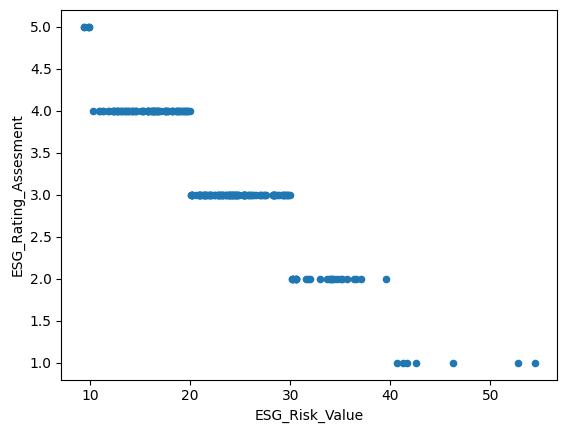

In [52]:
df.plot(kind='scatter',x='ESG_Risk_Value',y='ESG_Rating_Assesment') # so ye, looks like log reg <sigmoid function wld fit well>
# decreasing trend is evident tho; and when risk value is assigned groupings (negligible, low high) > can prob use linear regression

C:\Users\acer\AppData\Local\Temp\ipykernel_16484\3230694965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ESG_Risk_Cat_map']=df['ESG_Risk_Category'].map({'Negligible':0,'Low':1,'Medium':2,'High':3,'Severe':4})
c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


,ESG_Risk_Cat_map,ESG_Rating_Assesment
ESG_Risk_Cat_map,1.0,-1.0
ESG_Rating_Assesment,-1.0,1.0


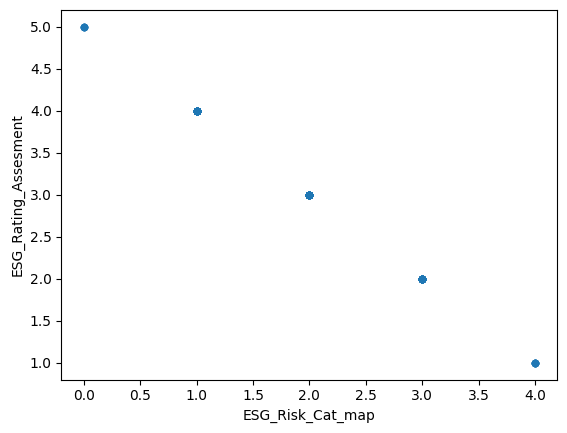

In [53]:
# in fact, let's see
df['ESG_Risk_Cat_map']=df['ESG_Risk_Category'].map({'Negligible':0,'Low':1,'Medium':2,'High':3,'Severe':4})
df.plot(kind='scatter',x='ESG_Risk_Cat_map',y='ESG_Rating_Assesment') # yep, das a linear rlnship aight
df[['ESG_Risk_Cat_map','ESG_Rating_Assesment']].corr() # esentially exact opposites > valid assumption of fn: risk assesment = 5 - risk_cat_map

In [54]:
stats.shapiro(df['ESG_Risk_Value']) # non-normal distribution   

ShapiroResult(statistic=0.9552001953125, pvalue=1.1052320587623399e-06)

In [55]:
df.groupby('Sector').median().sort_values(by='ESG_Risk_Value',ascending=True) # ironically, energy sector doesn't seem to be faring well

,ESG_Risk_Value,ESG_Rating_Assesment,ESG_Risk_Cat_map
Sector,,,
Real Estate,10.585,4.0,1.0
Technology,14.185,4.0,1.0
Consumer Discretionary,20.880,3.0,2.0
Financials,21.020,3.0,2.0
Utilities,21.940,3.0,2.0
Communication Services,22.280,3.0,2.0
Healthcare,22.620,3.0,2.0
Consumer Staples,24.050,3.0,2.0
Japan,25.360,3.0,2.0


In [56]:
df.groupby('Industry').median().sort_values(by='ESG_Risk_Value',ascending=True)

,ESG_Risk_Value,ESG_Rating_Assesment,ESG_Risk_Cat_map
Industry,,,
Rental & Leasing Services,9.940,5.0,0.0
REIT—Industrial,10.270,4.0,1.0
REIT—Specialty,10.900,4.0,1.0
Luxury Goods,11.615,4.0,1.0
Home Improvement Retail,12.235,4.0,1.0
...,...,...,...
Oil & Gas E&P,30.230,2.0,3.0
Financial Conglomerates,30.530,2.0,3.0
Other Industrial Metals & Mining,32.975,2.0,3.0
